<h1 style="text-align:center;font-size:30px;" > APS Failure Prediction </h1>

## 1. Business Problem

### 1.1 Objective

**** The task is to device a prediction model for judging whether or not a vehicle faces imminent failure of APS system .****

###  1.2 Description

<p> The dataset consists of data collected from heavy Scania 
trucks in everyday usage. 
The Air  Pressure System (APS)  is a type of function used in heavy vehicles to assist braking and gear changing. The APS failure dataset consists of the daily operational  sensor  data  from  failed  Scania  trucks. The dataset  is  crucial  to  the  manufacturer  as  it  allows  to isolate  components  which caused the failure.</p>

### 1.3 Real world problem and constraints

<p>1. Since we are provided with a dataset of failed scania trucks. The company wants to differentiate between the failure caused by the APS system and other failures. So that the reason for failure in the APS system can be detected easily and necessary changes can be made to avoid future failures. This will avoid a lot of expenses and will save time.</p>
<p>2. There are no latency issues.</p>
<p>3. Since company has kept the names of the attributes annonimized so interpretability won't be necessary.</p>

For further details, Refer: 1) https://people.dsv.su.se/~isak-kar/IDA2016Challenge.txt  
                            2) https://ida2016.blogs.dsv.su.se/?page_id=1387   <br>                                                  3)  https://www.researchgate.net/publication/330854331_An_Empirical_Comparison_of_Missing_Value_Imputation_Techniques_on_APS_Failure_Prediction

## 2. Machine Learning Problem

### 2.1 Data

### 2.1.1 Data Source

****Source**** : We can get the data from : https://archive.ics.uci.edu/ml/machine-learning-databases/00421/

### 2.1.2 Data Overview

<p>
    - The data is a csv file.<br>
    - Training data contains 171 columns.<br>
    - Number of rows in the train data are 60000.<br>
    - The test data has 16000 rows.<br>
    - Both the train data and test data have the class label column.
    - The data is highly imbalanced.<br>
    - The dataset has a lot of missing values.<br>
    - The data is numerical.
    - The datasets positive class consists of component failures for a specific component of the APS system. The negative class <br>       consists of trucks with failures for components not related to the APS.
</p>

### 2.2 Mapping real world problem to Machine learning problem

### 2.2.1 Type of Machine Learning Problem

It is a binary classification problem. For the given numerical data on some attributes of failed scania trucks systems we have to predict whether the failure is caused in the APS system or not.The data we have got is highly imbalanced dataset with a lot of missing values.

### 2.2.2 Performance Metric

Here we'll be dealing with a cost function. <br>

In [1]:
from prettytable import PrettyTable
x= PrettyTable(['', 0 ,1 ])
x.add_row([0,' TN ',' FP '])
x.add_row([1,' FN ',' TP '])
print(x)

+---+------+------+
|   |  0   |  1   |
+---+------+------+
| 0 |  TN  |  FP  |
| 1 |  FN  |  TP  |
+---+------+------+


In the above shown confusion matrix x-axis corresponds to the predicted class and the y-axis corresponds to the actual class.

The cost function we have is: <br>
>         Cost = FN X 500 + FP X 10 

FN = False Negative : Number of wrongly predicted no failures in the APS system .<br>
FP = False Positive : Number of wrongly predicted failure in the APS system . <br>
<space>As we can see that to penalize the False negatives the cost added by the FN's is more. We need to deal with the Sensitivity(Recall) primarily.

In [2]:
#importing libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import Imputer
import scikitplot as skplt
from prettytable import PrettyTable

### 2.3 Data Loading

In [3]:
df_train = pd.read_csv("ida_2016_training_set_update.csv")       #loading the train data

In [4]:
#Since our class label consists of 'pos' and 'neg' so we convert 'pos' into 1 and 'neg' into 0.
df_train['class'] = df_train['class'].map({'neg':0, 'pos':1})
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,0,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [5]:
y_train = df_train['class']                       #storing the train class labels
df_train.drop('class',axis=1, inplace=True)

In [6]:
df_test =pd.read_csv("aps_failure_test_set.csv")            #loading the test data
df_test.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,...,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,neg,66002,2,212,112,0,0,0,0,0,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,neg,59816,na,1010,936,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,neg,1814,na,156,140,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0


In [7]:
#Since our class label consists of 'pos' and 'neg' so we convert 'pos' into 1 and 'neg' into 0.
df_test['class'] = df_test['class'].map({'neg':0, 'pos':1})
df_test.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,60,0,20,12,0,0,0,0,0,...,1098,138,412,654,78,88,0,0,0,0
1,0,82,0,68,40,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,0,66002,2,212,112,0,0,0,0,0,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,0,59816,na,1010,936,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,0,1814,na,156,140,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0


In [8]:
y_test = df_test['class']                       #storing the test class labels
df_test.drop('class',axis=1, inplace=True)

In [9]:
print(np.bincount(y_train))
print(np.bincount(y_test))

[59000  1000]
[15625   375]


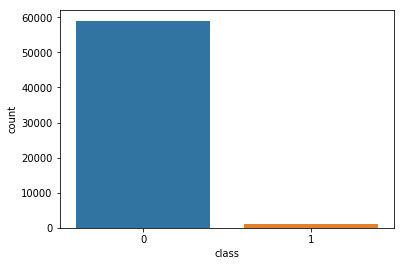

In [10]:
sns.countplot(y_train)               #train data class label countplot

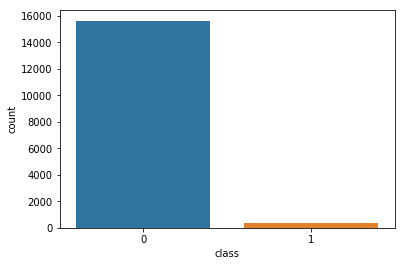

In [11]:
sns.countplot(y_test)                    #test data class label countplot

So from the above plot we can see that the data is highly imbalanced .

## 3. Data pre-processing and Imputation

In [12]:
# since our data has a string 'na' in place of NaN so we replace 'na' with NaN.
df_train= df_train.replace(to_replace='na', value=np.nan)
df_train.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698,NaN,2130706438,280,0,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,33058,NaN,0,NaN,0,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,41040,NaN,228,100,0,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,12,0,70,66,0,10,0,0,0,318,...,240,46,58,44,10,0,0,0,4,32
4,60874,NaN,1368,458,0,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [13]:
# Calculating the percentage of values missing in each column of our dataset
percent_missing= (df_train.isnull().sum() * 100) / len(df_train)
idx= np.argsort(-percent_missing)     #sorting the percent values in descending order
columns= df_train.columns
sorted(percent_missing)[:158:-1]

[82.10666666666667,
 81.20333333333333,
 79.56666666666666,
 77.22166666666666,
 77.215,
 77.215,
 73.34833333333333,
 65.915,
 45.461666666666666,
 38.39,
 24.768333333333334]

In [14]:
col_train = np.take(columns, idx[0:8])
print(col_train)

Index(['br_000', 'bq_000', 'bp_000', 'bo_000', 'ab_000', 'cr_000', 'bn_000',
       'bm_000'],
      dtype='object')


In [15]:
# since our data has a string 'na' in place of NaN so we replace 'na' with NaN.
df_test= df_test.replace(to_replace='na', value=np.nan)
df_test.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60,0,20,12,0,0,0,0,0,2682,...,1098,138,412,654,78,88,0,0,0,0
1,82,0,68,40,0,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,66002,2,212,112,0,0,0,0,0,199486,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,59816,NaN,1010,936,0,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,1814,NaN,156,140,0,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0


In [16]:
# Calculating the percentage of values missing in each column of our dataset
percent_missing_test= (df_test.isnull().sum() * 100) / len(df_test)
idx_test= np.argsort(-percent_missing_test)     #sorting the percent values in descending order
sorted(percent_missing_test)[:158:-1]

[82.05625,
 81.13125,
 79.50625,
 77.35,
 77.26875,
 77.26875,
 73.20625,
 65.9125,
 45.1625,
 38.0875,
 24.88125]

In [17]:
col_test = np.take(columns, idx_test[0:8])
print(col_test)

Index(['br_000', 'bq_000', 'bp_000', 'bo_000', 'ab_000', 'cr_000', 'bn_000',
       'bm_000'],
      dtype='object')


In [18]:
col_train==col_test      #checking if the same columns have missing values or not

array([ True,  True,  True,  True,  True,  True,  True,  True])

** We see that same columns in both train and test have missing value percentage of greater tan 50% , so we remove those columns because they will not add much value to our models.**

In [19]:
df_train = df_train.drop(col_train, axis=1)           # dropping the columns which have missing percent more than 50%
df_test = df_test.drop(col_test, axis=1)

Filling the missing values with the mean value of that particular column.

In [20]:
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)     #using mean imputations

C:\Users\ashwin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [21]:
undropped_columns= df_train.columns

In [22]:
imputer = imputer.fit(df_train)                                   #fitting the imputer on the train data
df_train= imputer.transform(df_train)                             #transforming on the train data and test data
df_test= imputer.transform(df_test)

In [23]:
df_train = pd.DataFrame(df_train, columns= undropped_columns)     #preparing new dataframe with imputations and undropped attributes
df_test = pd.DataFrame(df_test, columns= undropped_columns)

In [24]:
df_train.head()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [25]:
df_test.head()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,4736.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,82.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,748.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,66002.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,1358536.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,59816.0,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,0.0,123922.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,1814.0,156.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


### 3.1 Train and CV data

In [26]:
# We ll break the training data into train data and cv data. There are 10k cv points.
X_train , X_cv , y_tr , y_cv = train_test_split(df_train, y_train ,test_size= 0.25, stratify = y_train)

## 4. Utility Functions

In [54]:
def cost_fun(y_test, y_pred):
    '''This function is to calculate the cost '''
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp= cm.ravel()
    cost = 500*fn + 10*fp
    return cost,cm

In [55]:
def fun_thresh(thresholds1 , y_test ,pred_prob):
    '''This function is used to set a proper threshold probability value that gives the lowest cost. The main crux of using this function is explained below'''
    costs=[]
    best_cost = np.inf
    for threshold in tqdm(thresholds1): 
        pred = pred_prob[:,1] > threshold       #https://stackoverflow.com/questions/49785904/how-to-set-threshold-to-scikit-learn-random-forest-model
        cost , cm = cost_fun(y_test , pred)
        costs.append(cost)
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold
    return best_threshold, best_cost, costs

Here we ll be dealing with the probability thresholds which are set to 0.5 by default. Since we have class imbalance so high that if we ll deal with this cutoff probability of 0.5 we ll have all our things get messed up. So we ll try to change the cutoff probability from 0.5 to something else. <br>
If our cutoff probability is 0.5 then we give the equal weightage to both our class labels and this works when our data is balanced . But here we have our data highly imbalanced so we need to tackle with it by shifting our cutoff probability.<br>
__Sensitivity: __ True positive rate = Recall:- Of all the positive labels how many are correctly predicted to be positive . And thus recall helps in reducing our False Negatives. <br>
__Specificity: __ True Negative Rate :- Since we have to deal with a domain specific problem which wants us to deal with FN primarily so specificity is not under much of our concern.<br>
__Precision :__ Of all the positive class labels predicted how many of them are actually positive. We can see we have not much to do with precision . Its recall which is actually matter of concern.<br>
<space>
 Let us consider a simple special case where probability of class 0 in the training data point lies between 0 and 0.2 but evenly distributed in this probability range, and probability of class 1 in the training data point lies between 0.3 and 1, again evenly distributed in this probability range. Then, instead of going with the default cut off of 0.5(which corresponds to majority voting), maybe a better idea is to set the cut off at somewhere between 0.2 and 0.3, say at 0.25(which corresponds to weighted voting where one vote for class 1 is given three times as much weight as one vote for class 0).<br>
The most straightforward approach which I explained above is to use the ROC curve since it calculates the sensitivity and speciﬁcity across a continuum of cutoﬀs. Using this curve, an appropriate balance between sensitivity and speciﬁcity can be determined.<br>
We take all the threshold values and check for each threshold what cost we get and the threshold value for which we get the minimum cost becomes our optimal threshold value.<br>
For futher reading __Refer__ : https://www.linkedin.com/pulse/decoding-probabilities-random-forest-sanchit-tiwari <br>
    http://appliedpredictivemodeling.com/blog/2014/2/1/lw6har9oewknvus176q4o41alqw2ow <br>
    https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65


## 5. Machine Learning Models

### 5.1 Naive Bayes

In [56]:
gnb = GaussianNB()                  #we start with Naive bayes as a base model.
gnb.fit(df_train, y_train)          #fitting the data
gnb_pred = gnb.predict(df_test)     #predicting the test data
gnb_pred_prob= gnb.predict_proba(df_test)
gnb_pred_prob_train = gnb.predict_proba(df_train)

In [57]:
gnb_cost ,gnb_cm= cost_fun(y_test, gnb_pred)      #calculating the cost 
print(gnb_cost)

23590


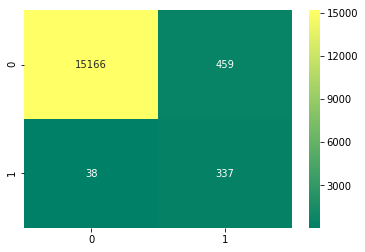

In [58]:
sns.heatmap(gnb_cm ,annot =True, fmt='d', cmap='summer')

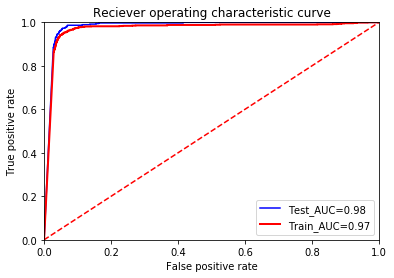

In [59]:
fpr , tpr, thresholds = roc_curve(y_train, gnb_pred_prob_train[:,1])
fpr1, tpr1 ,thresholds1 = roc_curve(y_test, gnb_pred_prob[:,1])

roc_auc = auc(fpr, tpr)
roc_auc1 = auc(fpr1, tpr1)

plt.plot(fpr1,tpr1,'b',label='Test_AUC=%0.2f' % roc_auc1)
plt.plot(fpr,tpr,'r',linewidth=2.0,label='Train_AUC=%0.2f' % roc_auc)

plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Reciever operating characteristic curve')
plt.legend()
plt.show()

In [34]:
gnb_best_threshold , gnb_min_cost, gnb_costs = fun_thresh(thresholds1, y_test , gnb_pred_prob)     #jump to threshold funtion

100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:05<00:00, 15.09it/s]


In [35]:
print("Best threshold is :", gnb_best_threshold, " and minimum cost is :", gnb_min_cost)

Best threshold is : 2.13359718212524e-72  and minimum cost is : 13870


In [192]:
gnb_pred_test = gnb.predict_proba(df_test)[:,1] > gnb_best_threshold
gnb_cost, gnb_cm = cost_fun(y_test, gnb_pred_test)   #jump to the cost fun

In [193]:
print("the cost is ",gnb_cost)

the cost is  13870


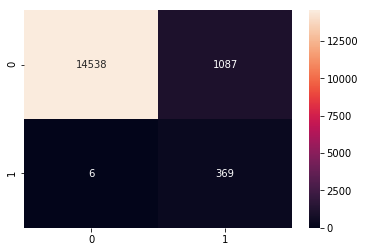

In [194]:
sns.heatmap(gnb_cm, annot=True , fmt='d')

###  5.2 Logistic Regression

In [60]:
import warnings
warnings.filterwarnings('ignore')
# performing hyperparameter tuning to get the best hyperparameters

C= [10**-4, 10**-2, 10**0 , 10**2, 10**4]
for i in C:
    lr= LogisticRegression(C=i, class_weight ='balanced')
    lr.fit(X_train, y_tr)
    lr_pred_cv = lr.predict(X_cv)
    lr_cv_cost , lr_cv_cm = cost_fun(y_cv , lr_pred_cv)    #jump to the cost function
    print(" Cost for C =", i ," is", lr_cv_cost)

 Cost for C = 0.0001  is 16680
 Cost for C = 0.01  is 16670
 Cost for C = 1  is 15720
 Cost for C = 100  is 16200
 Cost for C = 10000  is 17640


In [80]:
clf=LogisticRegression(C=1, class_weight='balanced')
clf.fit(df_train, y_train)
lr_pred= clf.predict(df_test)
lr_pred_prob = clf.predict_proba(df_test)
lr_pred_prob_train = clf.predict_proba(df_train)

In [81]:
lr_cost , lr_cm = cost_fun(y_test , lr_pred)   #jump to the cost function

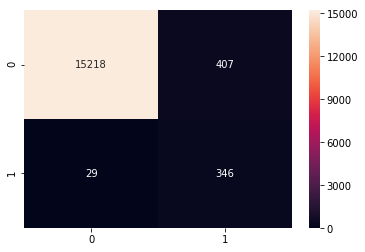

In [82]:
sns.heatmap(lr_cm , annot=True , fmt='d')

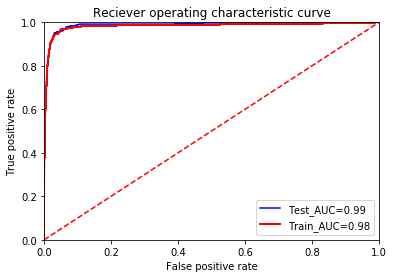

In [83]:
fpr , tpr, thresholds = roc_curve(y_train, lr_pred_prob_train[:,1])
fpr1, tpr1 ,thresholds1 = roc_curve(y_test, lr_pred_prob[:,1])

roc_auc = auc(fpr, tpr)
roc_auc1 = auc(fpr1, tpr1)

plt.plot(fpr1,tpr1,'b',label='Test_AUC=%0.2f' % roc_auc1)
plt.plot(fpr,tpr,'r',linewidth=2.0,label='Train_AUC=%0.2f' % roc_auc)

plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Reciever operating characteristic curve')
plt.legend()
plt.show()

In [84]:
lr_best_threshold , lr_min_cost ,lr_costs= fun_thresh(thresholds1, y_test , lr_pred_prob)

100%|████████████████████████████████████████████████████████████████████████████████| 292/292 [00:23<00:00, 12.63it/s]


In [85]:
print("Best threshold is :", lr_best_threshold, " and minimum cost is :", lr_min_cost)

Best threshold is : 0.39675014324663205  and minimum cost is : 14380


In [86]:
lr_pred_test = clf.predict_proba(df_test)[:,1] > lr_best_threshold
lr_cost, lr_cm = cost_fun(y_test, lr_pred_test)   #jump to the cost fun

In [87]:
print("The cost is ",lr_cost)

The cost is  14380


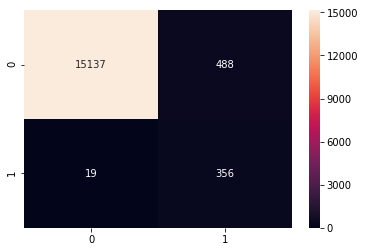

In [88]:
sns.heatmap(lr_cm, annot=True, fmt='d')

### 5.3 Random Forest

In [51]:
depth=[None,3,7,10]
estimators=[100,200,250,300]
score_cv=[]
for i in tqdm(estimators):
    score_c=[]
    for j in depth:
        rf=RandomForestClassifier(max_depth=j , n_estimators=i ,n_jobs=-1 )
        rf.fit(X_train, y_tr)                  #training our model
         
        rf_pred_cv=rf.predict(X_cv)            #predicting the cv data
        rf_cv_cost ,rf_cv_cm = cost_fun(y_cv , rf_pred_cv)
        score_c.append(rf_cv_cost)
    score_cv.append(score_c)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [08:21<00:00, 121.72s/it]


In [52]:
depth= [0,3,7,10]

In [53]:
score=np.array(score_cv)
score=score.ravel()
score=list(score)

In [54]:
d=depth*len(estimators)
e=estimators*len(depth)
e=sorted(e)

In [55]:
data=[]

data.append(score)
data.append(d)
data.append(e)

data=np.array(data)

In [56]:
df=pd.DataFrame(data.T,columns=['AUC','depth','estimators'])
df=df.pivot('depth','estimators','AUC')
df

estimators,100,200,250,300
depth,,,,
0,41660,45180,41180,43670
3,97090,93610,94570,95070
7,58610,58620,59100,56610
10,49130,49150,48650,49630


 Here 0 depth means depth = None


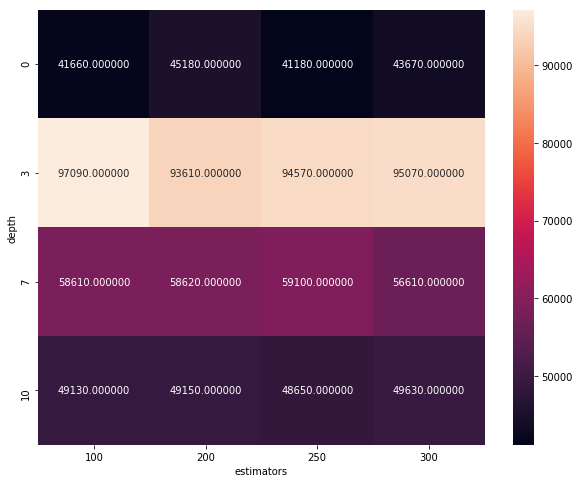

In [57]:
plt.figure(figsize=(10,8))
hm=sns.heatmap(df,annot=True,fmt='f')
print(" Here 0 depth means depth = None")

In [89]:
rf= RandomForestClassifier(n_estimators=250, max_depth =None , n_jobs=-1, random_state= 42)
rf.fit(df_train, y_train)
rf_pred_test= rf.predict(df_test)
rf_pred_prob = rf.predict_proba(df_test)
rf_pred_prob_train = rf.predict_proba(df_train)

In [90]:
rf_cost , rf_cm =cost_fun(y_test, rf_pred_test)

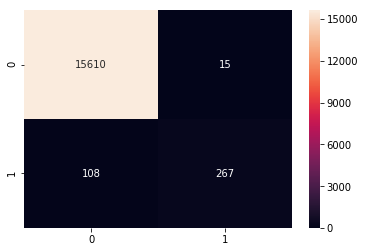

In [91]:
sns.heatmap(rf_cm , annot= True, fmt= 'd')

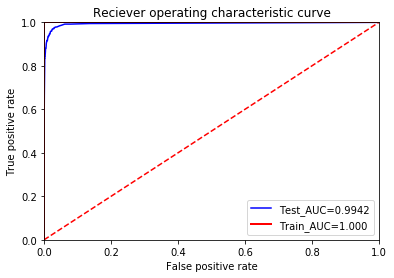

In [94]:
fpr , tpr, thresholds = roc_curve(y_train, rf_pred_prob_train[:,1])
fpr1, tpr1 ,thresholds1 = roc_curve(y_test, rf_pred_prob[:,1])

roc_auc = auc(fpr, tpr)
roc_auc1 = auc(fpr1, tpr1)

plt.plot(fpr1,tpr1,'b',label='Test_AUC=%0.4f' % roc_auc1)
plt.plot(fpr,tpr,'r',linewidth=2.0,label='Train_AUC=%0.3f' % roc_auc)

plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Reciever operating characteristic curve')
plt.legend()
plt.show()

In [95]:
rf_best_threshold , rf_min_cost , rf_costs= fun_thresh(thresholds1, y_test , rf_pred_prob)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.19it/s]


In [96]:
print("Best threshold is :", rf_best_threshold, " and minimum cost is :", rf_min_cost)

Best threshold is : 0.036  and minimum cost is : 9220


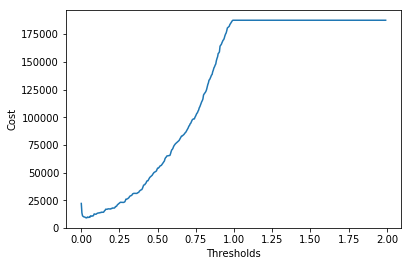

In [97]:
plt.plot(thresholds1, rf_costs)   
plt.xlabel('Thresholds')
plt.ylabel('Cost')
plt.show()

So we see that with increasing thresholds our cost is increasing too.

In [98]:
rf_pred_test = rf.predict_proba(df_test)[:,1] > rf_best_threshold
rf_cost, rf_cm = cost_fun(y_test, rf_pred_test)                  #jumpt to cost function

In [99]:
print("The cost is ", rf_cost)

The cost is  9220


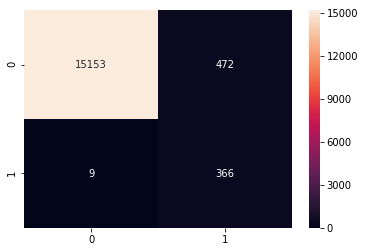

In [100]:
sns.heatmap(rf_cm, annot=True, fmt='d')

### 5.4 Gradient Boosting

In [157]:
depth=[3,4,5,6]
estimators=[50,100,150]
score_cv=[]
for i in tqdm(estimators):
    score_c=[]
    for j in depth:
        xg=xgb.XGBClassifier(max_depth=j , n_estimators=i ,n_jobs=-1 )
        xg.fit(X_train, y_tr)                  #training our model
         
        xg_pred_cv=xg.predict(X_cv)            #predicting the cv data
        xg_cv_cost ,xg_cv_cm = cost_fun(y_cv , xg_pred_cv)
        score_c.append(xg_cv_cost)
    score_cv.append(score_c)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [09:53<00:00, 179.21s/it]


In [158]:
score=np.array(score_cv)
score=score.ravel()
score=list(score)

In [159]:
d=depth*len(estimators)
e=estimators*len(depth)
e=sorted(e)

In [160]:
data=[]

data.append(score)
data.append(d)
data.append(e)

data=np.array(data)

In [161]:
df=pd.DataFrame(data.T,columns=['AUC','depth','estimators'])
df=df.pivot('depth','estimators','AUC')
df

estimators,50,100,150
depth,,,
3,51160,40710,39690
4,46170,39210,38190
5,41160,38690,38190
6,41710,40710,38200


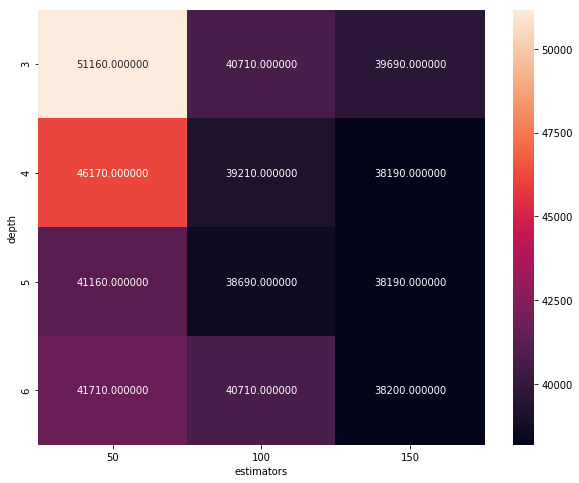

In [162]:
plt.figure(figsize=(10,8))
hm=sns.heatmap(df,annot=True,fmt='f')

In [70]:
xg= xgb.XGBClassifier(n_estimators=150, max_depth =5 , n_jobs=-1)
xg.fit(df_train, y_train)
xg_pred_test= xg.predict(df_test)
xg_pred_prob = xg.predict_proba(df_test)
xg_pred_prob_train = xg.predict_proba(df_train)

In [71]:
xg_cost , xg_cm =cost_fun(y_test, xg_pred_test)
print(xg_cost)

44670


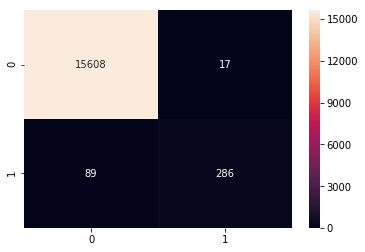

In [72]:
sns.heatmap(xg_cm , annot= True, fmt= 'd')

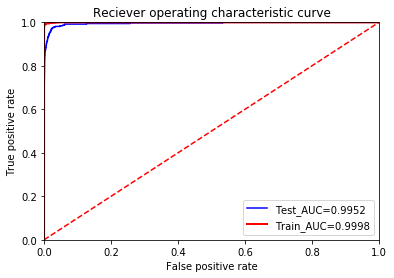

In [79]:
fpr , tpr, thresholds = roc_curve(y_train, xg_pred_prob_train[:,1])
fpr1, tpr1 ,thresholds1 = roc_curve(y_test, xg_pred_prob[:,1])

roc_auc = auc(fpr, tpr)
roc_auc1 = auc(fpr1, tpr1)

plt.plot(fpr1,tpr1,'b',label='Test_AUC=%0.4f' % roc_auc1)
plt.plot(fpr,tpr,'r',linewidth=2.0,label='Train_AUC=%0.4f' % roc_auc)

plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Reciever operating characteristic curve')
plt.legend()
plt.show()

In [167]:
xg_best_threshold , xg_min_cost, xg_costs = fun_thresh(thresholds1, y_test , xg_pred_prob)

100%|██████████████████████████████████████████████████████████████████████████████| 1611/1611 [01:59<00:00, 14.25it/s]


In [168]:
print("Best threshold is :", xg_best_threshold, " and minimum cost is :", xg_min_cost)

Best threshold is : 0.013913314  and minimum cost is : 8480


In [169]:
xg_pred_test = xg.predict_proba(df_test)[:,1] > xg_best_threshold
xg_cost, xg_cm = cost_fun(y_test, xg_pred_test)

In [170]:
print("The cost is ", xg_cost)

The cost is  8480


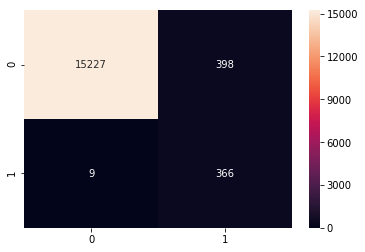

In [171]:
sns.heatmap(xg_cm, annot=True, fmt='d')

## 6. Conclusion

**** Following are the steps followed in solving this problem :****

- __Problem Description :__ We are provided with a problem in which we have to build a mode which predicts whether the the failure of the scania trucks is occurred by the failure of some specific parts in the APS system or not.<br>
- __Data Loading :__ Here we are provided with csv data files. Tran and test data files are given to us. <br>
- __Data understanding :__ Our train data and test data are highly imbalanced datasets with a lot of missing values , such that some attributes have a missing percentage of 82 % .<br>
- __Data Preprocessing :__ Since we have to deal with the numerical set of attributes. We drop the attributes with the missing value percentage of 50% or more from both the train and the test datasets and fill the rest of the attribute's missing values using mean imputation.<br>
- __Machine learning models :__ Now we start buildig our models:<br>
    1) __Naive bayes : __ We used Gaussian Naive Bayes as our data is numerical data. We build our base line model as Gaussian Naive bayes and record the cost.<br>
    2) __Logistic Regression :__ Now we build our linear model using Logistic Regression from sklearn and record the cost.<br>
    3) __Random Forest :__ Now we build our first ensemble model on top of the data first performing the hyperparameter tuning and chosing the best hyperparameters and then build our model and check its performance to record the cost value.<br>
    4) __ Gradient Boosting :__ Now we build our second ensemble model by first performing the hyperparameter tuning and then building the model on top of the data to record the cost value.<br>
- __Results :__ Now we compare the results of all the models:

In [184]:
y= PrettyTable(['Model','Threshold', 'Cost'])
y.add_row(['Naive Bayes', gnb_best_threshold,gnb_cost])
y.add_row(['Logistic Regression',lr_best_threshold,lr_cost])
y.add_row(['Random Forest',rf_best_threshold,rf_cost])
y.add_row(['XGBoost',xg_best_threshold,xg_cost])
print(y)

+---------------------+----------------------+-------+
|        Model        |      Threshold       |  Cost |
+---------------------+----------------------+-------+
|     Naive Bayes     | 2.13359718212524e-72 | 13870 |
| Logistic Regression |  0.2544006256494866  | 14600 |
|    Random Forest    |        0.036         |  9220 |
|       XGBoost       |     0.013913314      |  8480 |
+---------------------+----------------------+-------+
